In [1]:
from google.colab import drive
from torchvision.datasets import MNIST

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from torchvision import transforms, datasets
import os
import shutil
import random
import csv
import zipfile
import PIL
import math
from IPython.display import clear_output

In [3]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.size_z = size_z
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.network(x)
        return output

    def gen_shifted(self, x, shift):
        shift = torch.unsqueeze(shift, -1)
        shift = torch.unsqueeze(shift, -1)
        return self.forward(x + shift)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature

In [5]:
class LatentSpaceMapper:
    def __init__(self, generator: Generator, discriminator: Discriminator, device):
        self.generator: Generator = generator
        self.generator.to(device)
        self.discriminator: Discriminator = discriminator
        self.discriminator.to(device)
        self.device = device

    def map_image_to_point_in_latent_space(self, image: torch.Tensor, batch_size=1, size_z=100, max_opt_iterations=30000, opt_threshold=140.0, plateu_threshold=3.0, check_every_n_iter=4000, learning_rate=0.4, print_every_n_iters=10000, ignore_rules_below_threshold=50, retry_after_n_iters=10000, immediate_retry_threshold=200):
        image.to(self.device)
        z = torch.randn(batch_size, size_z, 1, 1, device=self.device, requires_grad=True)
        z_optimizer = torch.optim.Adam([z], lr=learning_rate)
        losses = []
        final_loss = 0
        latest_checkpoint_loss = 0

        # scheduler = lr_scheduler.LinearLR(z_optimizer, start_factor=0.4, end_factor=0.001, total_iters=max_opt_iterations-(math.floor(max_opt_iterations*0.2)))
        # scheduler = lr_scheduler.StepLR(z_optimizer, step_size=max_opt_iterations, gamma=0.9)
        # scheduler = torch.optim.lr_scheduler.CyclicLR(z_optimizer, base_lr=0.01, max_lr=0.4, cycle_momentum=False)
        for i in range(max_opt_iterations):
            retry = False
            loss = self.__get_anomaly_score(z, image.unsqueeze(0).to(self.device))
            loss.backward()
            z_optimizer.step()
            final_loss = loss.data.item()

            if i == 1:
                latest_checkpoint_loss = loss.data.item()

            if loss.data.item() < opt_threshold*batch_size:
                print(f"Iteration: {i} -- Reached Defined Optimum -- Final Loss: {loss.data.item()}")
                break

            if (i % print_every_n_iters == 0 and i != 0) or (i == max_opt_iterations-1):
                print(f"Iteration: {i} -- Current Loss: {loss.data.item()} -- Current Learning-Rate: {z_optimizer.param_groups[0]['lr']}")
                losses.append(loss.data.item())

            if i % check_every_n_iter == 0 and i != 0:
                if abs(loss.data.item()-latest_checkpoint_loss) < plateu_threshold:
                    print(f"Reached Plateu at Iteration {i} -- Loss: {loss.data.item()}")
                    retry = True
                    break
                if loss.data.item() > immediate_retry_threshold:
                    print(f"Loss at Iteration {i} too high -- Loss: {loss.data.item()}")
                    retry = True
                    break
                latest_checkpoint_loss = loss.data.item()

            if i == retry_after_n_iters and loss.data.item() > ignore_rules_below_threshold:
                retry = True
                break

            #scheduler.step()

        return z, final_loss, retry

    def __get_anomaly_score(self, z, x_query):
        lamda = 0.1
        g_z = self.generator(z.to(self.device))
        loss_r = torch.sum(torch.abs(x_query - g_z))

        return loss_r

        #_, x_prop = self.discriminator(x_query)
        #_, g_z_prop = self.discriminator(g_z)
        #loss_d = torch.sum(torch.abs(x_prop - g_z_prop))
        #return (1 - lamda) * loss_r + lamda * loss_d


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_color_channels = 1
num_feature_maps_g = 64
num_feature_maps_d = 64
size_z = 100

device

device(type='cuda')

In [7]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab/saved_models/generator.pkl", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab/saved_models/discriminator.pkl', map_location=torch.device(device)))

<All keys matched successfully>

In [8]:
def get_ano_class_mnist_dataset(root_dir, norm_class=9, ano_class=6, ano_fraction=0.1):
    mnist_dataset = MNIST(
        root=root_dir,
        train=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(.5,), std=(.5,))
        ]),
        download=True,
    )

    norms = [d for d in mnist_dataset if (d[1] == norm_class)]
    anos = [d for d in mnist_dataset if (d[1] == ano_class)]

    dataset = torch.utils.data.ConcatDataset([norms, anos[:round(ano_fraction*len(anos))]])
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

    return dataloader

data = get_ano_class_mnist_dataset(root_dir='/content/drive/MyDrive/Colab/data')

6541 images left
Iteration: 5000 -- Current Loss: 57.509796142578125 -- Current Learning-Rate: 0.1
Iteration: 10000 -- Current Loss: 50.333702087402344 -- Current Learning-Rate: 0.1
Iteration: 10652 -- Reached Defined Optimum -- Final Loss: 49.99961471557617
Original Image


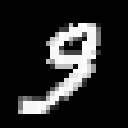

Mapped and Reconstructed Image


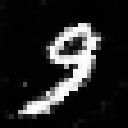

-----------------------
6540 images left
Iteration: 577 -- Reached Defined Optimum -- Final Loss: 49.986900329589844
Original Image


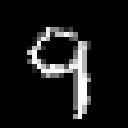

Mapped and Reconstructed Image


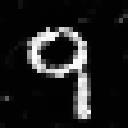

-----------------------
6539 images left
Iteration: 435 -- Reached Defined Optimum -- Final Loss: 49.99810028076172
Original Image


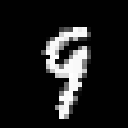

Mapped and Reconstructed Image


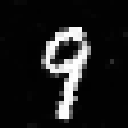

-----------------------
6538 images left
Loss at Iteration 4000 too high -- Loss: 87.75917053222656
Could not find optimal region within the defined iteration count. Retry (1) with another random z...
6538 images left


In [ ]:
from torch.cuda import reset_max_memory_allocated
def create_cp(iteration_number):
  print("CREATING CHECKPOINT...")
  drive.mount('/content/drive', force_remount=True)
  shutil.make_archive(f"/content/drive/MyDrive/Colab/data/latent_space_mappings_cp/latent_space_mappings_cp{iteration_number}", 'zip', "/content/data/latent_space_mappings")

def save_to_drive(mapped_z, iteration_number, csv_path):
  torch.save(mapped_z, f'/content/drive/MyDrive/Colab/data/latent_space_mappings/mapped_z_{iteration_number}.pt')
  shutil.copy(csv_path, "/content/drive/MyDrive/Colab/data/latent_space_mappings/latent_space_mappings.csv")

base_folder = "/content/data/latent_space_mappings"
csv_path = os.path.join(base_folder, "latent_space_mappings.csv")


prepare_target_folder = True
if prepare_target_folder:
    if not os.path.exists(base_folder):
        os.makedirs(base_folder, exist_ok=True)

    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)
        os.makedirs(base_folder, exist_ok=True)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "reconstruction_loss"]
        writer.writerow(fields)

# Start mapping
map_anomalies = True
map_normals = True
t = transforms.ToPILImage()
lsm: LatentSpaceMapper = LatentSpaceMapper(generator=generator, discriminator=discriminator, device=device)
mapped_images = []
cp_counter = 0
counter = len(data)

i = 0
retry_counter = 0

for d in iter(data):
    if i % 50 == 0 and i != 0:
        clear_output()
        print("Cleared Output...")

    print(f"{counter} images left")

    max_retries = 20
    opt_threshold=50
    ignore_rules_below_threshold=55
    immediate_retry_threshold=65
    max_opt_iterations=25000

    if (d[1] == 6 and map_anomalies) or (d[1] == 9 and map_normals):
        mapped_z, reconstruction_loss, retry = lsm.map_image_to_point_in_latent_space(d[0][0],
                                                                            batch_size=1,
                                                                            max_opt_iterations=max_opt_iterations,
                                                                            plateu_threshold=0.0005,
                                                                            check_every_n_iter=4000,
                                                                            learning_rate=0.1,
                                                                            print_every_n_iters=5000,
                                                                            retry_after_n_iters=10000,
                                                                            ignore_rules_below_threshold=ignore_rules_below_threshold,
                                                                            opt_threshold=opt_threshold,
                                                                            immediate_retry_threshold=immediate_retry_threshold)

        if retry:
            if retry_counter == max_retries:
                retry_counter = 0
                i+=1
                counter-=1
                print("Retry Limit reached. Moving on to next sample")
                print('Original Image That Could Not Be Mapped')
                t(d[0][0]).resize((128, 128), PIL.Image.NEAREST).show()
                print('-----------------------')
                continue
            else:
                retry_counter += 1
                print(f"Could not find optimal region within the defined iteration count. Retry ({retry_counter}) with another random z...")
                continue

        retry_counter = 0
        mapped_images.append(mapped_z)
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'mapped_z_{counter}.pt', d[1], math.floor(reconstruction_loss)]
            writer.writerow(fields)

        torch.save(mapped_z, os.path.join(base_folder, f'mapped_z_{counter}.pt'))
        save_to_drive(mapped_z, counter, csv_path)
        cp_counter += 1
        if cp_counter % 50 == 0:
            create_cp(counter)
            clear_output

        print('Original Image')
        display(t(d[0][0]).resize((128, 128), PIL.Image.NEAREST))
        print('Mapped and Reconstructed Image')
        original_img = generator(mapped_z).cpu()
        display(t(original_img[0]).resize((128, 128), PIL.Image.NEAREST))
        print('-----------------------')

    i+=1
    counter-=1

create_cp(0)